#Overview
1. Integrating Google Colab with a local runtime
2. Installing ML Flow and basic use case
3. Logging parameters, metrics with MLFlow
4. Logging image artifacts with MLFlow
5. Logging PyTorch models with MLFlow and loading them

#Google Colab with local runtime

1. Click on arrow on top right corner next to RAM and Disk
2. Click connect to a local runtime
3. Click on "these instructions" and read thoroughly
4. Then follow the "setup instructions" (Note: use pip3 not pip)
5. Type the "Start Server and Authenticate" code on terminal and get link
6. Again click on arrow on top right corner next to RAM and Disk. Then click on "connect to a local runtime"
7. Copy+Paste the given link in the terminal here and click connect
8. The "RAM and Disk" on top right of this screen should change to "Connected(Local)"
9. On the left panel, the files should be those on your local computer instead of google cloud

#Installing MLFlow

1. Open a terminal
2. pip3 install mlflow
3. cd Desktop (Same location as that connected to google colab - done in the previous step)
4. mlflow ui
5. Copy url from "Listening to" part in new tab

#Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

In [ ]:
!pip3 install mlflow
import mlflow
import mlflow.pytorch

In [ ]:
class Params(object):
  def __init__(self, batch_size, epochs, seed, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.log_interval = log_interval

args = Params(265, 4, 0, 20)

#Datasets

In [ ]:
transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))  #MNIST has only 1 channel
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=True)

#Model

In [ ]:
class Model(nn.Module):
  def __init__(self, nH=32):
    super(Model, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784,nH),            # 28 x 28 = 784
        nn.ReLU(),
        nn.Linear(nH,10),
    )

  def forward(self,x):
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:
def train(epoch):

  model.train()

  for batch_id, data in enumerate(train_loader):
    inputs, labels = data

    opt.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if batch_id % args.log_interval == 0:
      pos = epoch * len(train_loader) + batch_id
      mlflow.log_metric('train loss', loss.data.item()/len(inputs)*1000)

      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(epoch, batch_id*len(inputs), len(train_loader.dataset),
                                                                     100.*batch_id/len(train_loader), loss.data.item()))

In [ ]:
def test(epoch):

  model.eval()
  test_loss = 0
  correct = 0
  confusion_matrix = np.zeros([10, 10])

  with torch.no_grad():

    for inputs,labels in test_loader:
      outputs = model(inputs)
      test_loss += loss_fn(outputs, labels).data.item()
      pred = outputs.data.max(1)[1]
      correct += pred.eq(labels.data).sum().item()

      for x,y in zip(pred.numpy(), labels.numpy()):
        confusion_matrix[x][y] += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)

    pos = (epoch+1) * len(train_loader)
    mlflow.log_metric('test_loss ', test_loss*1000)
    mlflow.log_metric('test_accuracy ', test_accuracy)

    print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
          format(test_loss, correct, len(test_loader.dataset), test_accuracy))
    
    if epoch == args.epochs:
      classes = np.arange(10)
      fig, ax = plt.subplots()
      im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)
      ax.set(xticks=np.arange(confusion_matrix.shape[1]),
             yticks=np.arange(confusion_matrix.shape[0]),
             xticklabels=classes, yticklabels=classes,
             ylabel='True Label',
             xlabel='Predicted Label',
             title='Epoch %d' %epoch)
      thresh = confusion_matrix.max() / 2.

      for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
          ax.text(j, i, int(confusion_matrix[i,j]), ha='center', va='center',
                  color='white' if confusion_matrix[i,j] > thresh else 'black')
      
      fig.tight_layout()

      image_path = 'images/%s.png' %(expt_id)
      plt.savefig(image_path)
      mlflow.log_artifact(image_path)

#Hyper Parameter Tuning Loop


LR =  0.01 ; Momentum =  0.90 ; Hidden Nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.389
Train Epoch: 1 [5300/60000 (9%)]	Loss: 1.393
Train Epoch: 1 [10600/60000 (18%)]	Loss: 0.644
Train Epoch: 1 [15900/60000 (26%)]	Loss: 0.468
Train Epoch: 1 [21200/60000 (35%)]	Loss: 0.313
Train Epoch: 1 [26500/60000 (44%)]	Loss: 0.456
Train Epoch: 1 [31800/60000 (53%)]	Loss: 0.464
Train Epoch: 1 [37100/60000 (62%)]	Loss: 0.367
Train Epoch: 1 [42400/60000 (70%)]	Loss: 0.297
Train Epoch: 1 [47700/60000 (79%)]	Loss: 0.279
Train Epoch: 1 [53000/60000 (88%)]	Loss: 0.323
Train Epoch: 1 [58300/60000 (97%)]	Loss: 0.341


2021/09/19 13:05:01 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:01 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0011, Accuracy: 9168/10000 (92%)



2021/09/19 13:05:03 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.373
Train Epoch: 2 [5300/60000 (9%)]	Loss: 0.307
Train Epoch: 2 [10600/60000 (18%)]	Loss: 0.258
Train Epoch: 2 [15900/60000 (26%)]	Loss: 0.342
Train Epoch: 2 [21200/60000 (35%)]	Loss: 0.256
Train Epoch: 2 [26500/60000 (44%)]	Loss: 0.190
Train Epoch: 2 [31800/60000 (53%)]	Loss: 0.361
Train Epoch: 2 [37100/60000 (62%)]	Loss: 0.208
Train Epoch: 2 [42400/60000 (70%)]	Loss: 0.302
Train Epoch: 2 [47700/60000 (79%)]	Loss: 0.303
Train Epoch: 2 [53000/60000 (88%)]	Loss: 0.250
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.270


2021/09/19 13:05:15 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0010, Accuracy: 9245/10000 (92%)



2021/09/19 13:05:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.311
Train Epoch: 3 [5300/60000 (9%)]	Loss: 0.164
Train Epoch: 3 [10600/60000 (18%)]	Loss: 0.219
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.265
Train Epoch: 3 [21200/60000 (35%)]	Loss: 0.203
Train Epoch: 3 [26500/60000 (44%)]	Loss: 0.213
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.277
Train Epoch: 3 [37100/60000 (62%)]	Loss: 0.338
Train Epoch: 3 [42400/60000 (70%)]	Loss: 0.300
Train Epoch: 3 [47700/60000 (79%)]	Loss: 0.322
Train Epoch: 3 [53000/60000 (88%)]	Loss: 0.315
Train Epoch: 3 [58300/60000 (97%)]	Loss: 0.292


2021/09/19 13:05:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:28 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0009, Accuracy: 9311/10000 (93%)



2021/09/19 13:05:30 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.268
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.154
Train Epoch: 4 [10600/60000 (18%)]	Loss: 0.222
Train Epoch: 4 [15900/60000 (26%)]	Loss: 0.245
Train Epoch: 4 [21200/60000 (35%)]	Loss: 0.175
Train Epoch: 4 [26500/60000 (44%)]	Loss: 0.194
Train Epoch: 4 [31800/60000 (53%)]	Loss: 0.223
Train Epoch: 4 [37100/60000 (62%)]	Loss: 0.136
Train Epoch: 4 [42400/60000 (70%)]	Loss: 0.254
Train Epoch: 4 [47700/60000 (79%)]	Loss: 0.177
Train Epoch: 4 [53000/60000 (88%)]	Loss: 0.275
Train Epoch: 4 [58300/60000 (97%)]	Loss: 0.186

Test set: Average Loss: 0.0008, Accuracy: 9354/10000 (94%)



2021/09/19 13:05:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:44 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label


LR =  0.01 ; Momentum =  0.90 ; Hidden Nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313
Train Epoch: 1 [5300/60000 (9%)]	Loss: 1.280
Train Epoch: 1 [10600/60000 (18%)]	Loss: 0.597
Train Epoch: 1 [15900/60000 (26%)]	Loss: 0.420
Train Epoch: 1 [21200/60000 (35%)]	Loss: 0.436
Train Epoch: 1 [26500/60000 (44%)]	Loss: 0.458
Train Epoch: 1 [31800/60000 (53%)]	Loss: 0.342
Train Epoch: 1 [37100/60000 (62%)]	Loss: 0.353
Train Epoch: 1 [42400/60000 (70%)]	Loss: 0.307
Train Epoch: 1 [47700/60000 (79%)]	Loss: 0.310
Train Epoch: 1 [53000/60000 (88%)]	Loss: 0.208
Train Epoch: 1 [58300/60000 (97%)]	Loss: 0.307


2021/09/19 13:05:56 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:05:56 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0011, Accuracy: 9184/10000 (92%)



2021/09/19 13:05:58 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.278
Train Epoch: 2 [5300/60000 (9%)]	Loss: 0.278
Train Epoch: 2 [10600/60000 (18%)]	Loss: 0.310
Train Epoch: 2 [15900/60000 (26%)]	Loss: 0.294
Train Epoch: 2 [21200/60000 (35%)]	Loss: 0.229
Train Epoch: 2 [26500/60000 (44%)]	Loss: 0.229
Train Epoch: 2 [31800/60000 (53%)]	Loss: 0.274
Train Epoch: 2 [37100/60000 (62%)]	Loss: 0.335
Train Epoch: 2 [42400/60000 (70%)]	Loss: 0.268
Train Epoch: 2 [47700/60000 (79%)]	Loss: 0.163
Train Epoch: 2 [53000/60000 (88%)]	Loss: 0.232
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.219


2021/09/19 13:06:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:06:09 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0009, Accuracy: 9336/10000 (93%)



2021/09/19 13:06:11 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.231
Train Epoch: 3 [5300/60000 (9%)]	Loss: 0.185
Train Epoch: 3 [10600/60000 (18%)]	Loss: 0.249
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.240
Train Epoch: 3 [21200/60000 (35%)]	Loss: 0.236
Train Epoch: 3 [26500/60000 (44%)]	Loss: 0.300
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.231
Train Epoch: 3 [37100/60000 (62%)]	Loss: 0.211
Train Epoch: 3 [42400/60000 (70%)]	Loss: 0.252
Train Epoch: 3 [47700/60000 (79%)]	Loss: 0.286
Train Epoch: 3 [53000/60000 (88%)]	Loss: 0.182
Train Epoch: 3 [58300/60000 (97%)]	Loss: 0.306


2021/09/19 13:06:23 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:06:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0008, Accuracy: 9387/10000 (94%)



2021/09/19 13:06:25 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.147
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.253
Train Epoch: 4 [10600/60000 (18%)]	Loss: 0.264
Train Epoch: 4 [15900/60000 (26%)]	Loss: 0.180
Train Epoch: 4 [21200/60000 (35%)]	Loss: 0.266
Train Epoch: 4 [26500/60000 (44%)]	Loss: 0.201
Train Epoch: 4 [31800/60000 (53%)]	Loss: 0.242
Train Epoch: 4 [37100/60000 (62%)]	Loss: 0.262
Train Epoch: 4 [42400/60000 (70%)]	Loss: 0.155
Train Epoch: 4 [47700/60000 (79%)]	Loss: 0.212
Train Epoch: 4 [53000/60000 (88%)]	Loss: 0.157
Train Epoch: 4 [58300/60000 (97%)]	Loss: 0.127

Test set: Average Loss: 0.0007, Accuracy: 9434/10000 (94%)



2021/09/19 13:06:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:06:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:06:39 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label


LR =  0.01 ; Momentum =  0.90 ; Hidden Nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.367
Train Epoch: 1 [5300/60000 (9%)]	Loss: 1.012
Train Epoch: 1 [10600/60000 (18%)]	Loss: 0.528
Train Epoch: 1 [15900/60000 (26%)]	Loss: 0.403
Train Epoch: 1 [21200/60000 (35%)]	Loss: 0.412
Train Epoch: 1 [26500/60000 (44%)]	Loss: 0.422
Train Epoch: 1 [31800/60000 (53%)]	Loss: 0.362
Train Epoch: 1 [37100/60000 (62%)]	Loss: 0.381
Train Epoch: 1 [42400/60000 (70%)]	Loss: 0.239
Train Epoch: 1 [47700/60000 (79%)]	Loss: 0.281
Train Epoch: 1 [53000/60000 (88%)]	Loss: 0.228
Train Epoch: 1 [58300/60000 (97%)]	Loss: 0.314


2021/09/19 13:06:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:06:50 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0010, Accuracy: 9194/10000 (92%)



2021/09/19 13:06:52 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.257
Train Epoch: 2 [5300/60000 (9%)]	Loss: 0.301
Train Epoch: 2 [10600/60000 (18%)]	Loss: 0.236
Train Epoch: 2 [15900/60000 (26%)]	Loss: 0.324
Train Epoch: 2 [21200/60000 (35%)]	Loss: 0.202
Train Epoch: 2 [26500/60000 (44%)]	Loss: 0.381
Train Epoch: 2 [31800/60000 (53%)]	Loss: 0.399
Train Epoch: 2 [37100/60000 (62%)]	Loss: 0.295
Train Epoch: 2 [42400/60000 (70%)]	Loss: 0.223
Train Epoch: 2 [47700/60000 (79%)]	Loss: 0.241
Train Epoch: 2 [53000/60000 (88%)]	Loss: 0.270
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.274


2021/09/19 13:07:04 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:07:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0008, Accuracy: 9370/10000 (94%)



2021/09/19 13:07:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.192
Train Epoch: 3 [5300/60000 (9%)]	Loss: 0.291
Train Epoch: 3 [10600/60000 (18%)]	Loss: 0.255
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.130
Train Epoch: 3 [21200/60000 (35%)]	Loss: 0.151
Train Epoch: 3 [26500/60000 (44%)]	Loss: 0.144
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.222
Train Epoch: 3 [37100/60000 (62%)]	Loss: 0.227
Train Epoch: 3 [42400/60000 (70%)]	Loss: 0.148
Train Epoch: 3 [47700/60000 (79%)]	Loss: 0.132
Train Epoch: 3 [53000/60000 (88%)]	Loss: 0.168
Train Epoch: 3 [58300/60000 (97%)]	Loss: 0.204


2021/09/19 13:07:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:07:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average Loss: 0.0007, Accuracy: 9478/10000 (95%)



2021/09/19 13:07:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.168
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.144
Train Epoch: 4 [10600/60000 (18%)]	Loss: 0.234
Train Epoch: 4 [15900/60000 (26%)]	Loss: 0.136
Train Epoch: 4 [21200/60000 (35%)]	Loss: 0.186
Train Epoch: 4 [26500/60000 (44%)]	Loss: 0.156
Train Epoch: 4 [31800/60000 (53%)]	Loss: 0.114
Train Epoch: 4 [37100/60000 (62%)]	Loss: 0.126
Train Epoch: 4 [42400/60000 (70%)]	Loss: 0.162
Train Epoch: 4 [47700/60000 (79%)]	Loss: 0.147
Train Epoch: 4 [53000/60000 (88%)]	Loss: 0.232
Train Epoch: 4 [58300/60000 (97%)]	Loss: 0.212

Test set: Average Loss: 0.0006, Accuracy: 9551/10000 (96%)



2021/09/19 13:07:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:07:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/19 13:07:33 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label

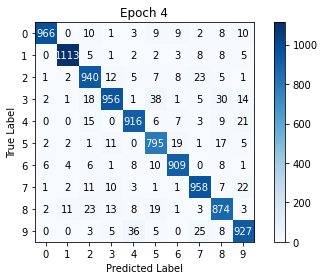

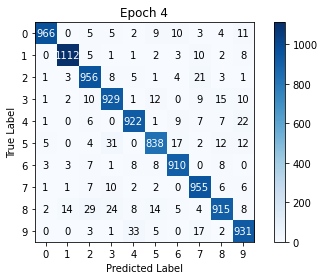

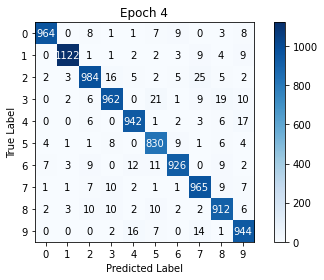

In [ ]:
#mlflow.create_experiment('fixed lr and momentum')
mlflow.set_experiment('fixed lr and momentum')

#for lr in [0.01, 0.05, 0.1]:
for lr in [0.01]:
  #for momentum in [0.9, 0.92, 0.95]:
  for momentum in [0.9]:
    for hidden_nodes in [16, 32, 48]:

      expt_id = '%d_%d_%d' %(int(lr*100), int(momentum*100), hidden_nodes)

      print('\nLR =  %.2f ; Momentum =  %.2f ; Hidden Nodes = %d\n' %(lr, momentum, hidden_nodes))

      model = Model(hidden_nodes)

      loss_fn = nn.CrossEntropyLoss()
      opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key, value)
        mlflow.log_param('lr', lr)
        mlflow.log_param('momentum', momentum)
        mlflow.log_param('hidden_nodes', hidden_nodes)

        for epoch in range(1, args.epochs+1):
          train(epoch)
          test(epoch)

          mlflow.pytorch.log_model(model, 'models')

#Loading and Visualising a Model

In [ ]:
model_load = mlflow.pytorch.load_model('models', run_id='1c6a31541d014e649641912c5b8c8911')

OSError: ignored

In [ ]:
weight_layer0 = list(model_load.parameeters())[0].data.numpy()

In [ ]:
sns.distplot(weight_layer0.ravel())
plt.plot()

In [ ]:
sns.heatmap(np.abs(weight_layer0))
plt.plot()

In [ ]:
weight_layer1 = list(model_load.parameeters())[2].data.numpy()

In [ ]:
weight_layer1.shape

In [ ]:
sns.distplot(weight_layer1.ravel())
plt.plot()

In [ ]:
sns.heatmap(np.abs(weight_layer1))
plt.plot()

In [ ]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48):
  ax1 = fig.add_subplot(nrows, ncols, i+1)
  sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28,28)), ax=ax1, cbar=False)
  ax1.axis('off')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_title(i)
plt.tight_layout()
plt.show()